# Hybrid Approach (CNN-BiLSTM)

In [1]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import (Input, Embedding, SpatialDropout1D, Conv1D,
                                     BatchNormalization, Dropout, GlobalMaxPooling1D,
                                     Bidirectional, LSTM, Dense, concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from gensim.downloader import load as gensim_load
from sklearn.metrics import confusion_matrix, classification_report
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2025-06-01 07:14:45.335470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748762085.811078      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748762085.931640      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the dataset
df = pd.read_csv("/kaggle/input/dataset1/D1.csv")

In [3]:
# Drop the unnecessary column if it exists
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)


In [4]:
# Drop rows with missing values and show new shape
df.dropna(inplace=True)
print("\nShape after dropping missing values:", df.shape)


Shape after dropping missing values: (52681, 2)


In [5]:
# Check distribution of status before resampling
print("\nStatus Value Counts before resampling:")
print(df['status'].value_counts())


Status Value Counts before resampling:
status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


In [6]:
# Data Resampling for Class Balance
def resample_data(df):
    max_count = df['status'].value_counts().max()
    df_resampled = pd.DataFrame()
    for status in df['status'].unique():
        df_class = df[df['status'] == status]
        if len(df_class) < max_count:
            df_class_resampled = resample(df_class, replace=True, n_samples=max_count, random_state=42)
            df_resampled = pd.concat([df_resampled, df_class_resampled])
        else:
            df_resampled = pd.concat([df_resampled, df_class])
    return df_resampled

df = resample_data(df)
print("Value counts after resampling:")
print(df['status'].value_counts())

Value counts after resampling:
status
Anxiety                 16343
Normal                  16343
Depression              16343
Suicidal                16343
Stress                  16343
Bipolar                 16343
Personality disorder    16343
Name: count, dtype: int64


In [7]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text.lower())
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['statement'] = df['statement'].apply(preprocess_text)
print("\nSample preprocessed text:")
print(df['statement'].head())



Sample preprocessed text:
52349    must find something wrong relationship girlfri...
52697    water slide going sound stupid lol basically g...
34039    insomnia last month suddenly developed worst c...
34473    tired wasting money time know nothing wrong im...
34309    head nodding tic cause long term damage hey iv...
Name: statement, dtype: object


In [8]:
# Splitting Data and Encoding Labels
X = df['statement'].values
y = df['status'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (91520,) (91520, 7)
Testing set shape: (22881,) (22881, 7)


In [9]:
# Tokenization and Padding
max_words = 50000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')
print("Padded Training Data Shape:", X_train_padded.shape)
print("Padded Testing Data Shape:", X_test_padded.shape)

Padded Training Data Shape: (91520, 100)
Padded Testing Data Shape: (22881, 100)


In [10]:
# Load Pre-trained Word2Vec and Build Embedding Matrix
print("Downloading the pre-trained Google News Word2Vec model. This may take a while...")
word2vec_model = gensim_load("word2vec-google-news-300")
embedding_dim = word2vec_model.vector_size  
print("Download complete. Embedding dimension:", embedding_dim)

word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
found_count = 0

for word, i in word_index.items():
    if i >= max_words:
        continue
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
        found_count += 1
    else:
        # Initialize missing words with random vectors
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

print(f"Found embeddings for {found_count} out of {num_words} words.")


[==============------------------------------------] 28.6% 475.1/1662.8MB downloadedDownload complete. Embedding dimension: 300
Found embeddings for 26005 out of 50000 words.


In [11]:
# Building the Enhanced Hybrid CNN + BiLSTM Model
# Using the Functional API for a parallel architecture:
input_layer = Input(shape=(max_sequence_length,), name='input_text')
embedding_layer = Embedding(input_dim=num_words,
                            output_dim=embedding_dim,
                            input_length=max_sequence_length,
                            weights=[embedding_matrix],
                            trainable=True,
                            name='embedding')(input_layer)
drop_embedding = SpatialDropout1D(0.3, name='spatial_dropout')(embedding_layer)

# CNN Branch: apply several 1D convolutions and global pooling
conv1 = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu', name='conv1_3')(drop_embedding)
bn1   = BatchNormalization(name='bn1')(conv1)
conv2 = Conv1D(filters=256, kernel_size=4, padding='same', activation='relu', name='conv2_4')(bn1)
bn2   = BatchNormalization(name='bn2')(conv2)
conv3 = Conv1D(filters=256, kernel_size=5, padding='same', activation='relu', name='conv3_5')(bn2)
bn3   = BatchNormalization(name='bn3')(conv3)
pool  = GlobalMaxPooling1D(name='global_max_pool')(bn3)

# BiLSTM Branch: capture sequential context
bilstm = Bidirectional(LSTM(units=128, dropout=0.3, recurrent_dropout=0.3), name='bilstm')(drop_embedding)
drop_bilstm = Dropout(0.5, name='drop_bilstm')(bilstm)

# Merge both branches
merged = concatenate([pool, drop_bilstm], name='concatenate')

# Fully connected layers after merging
fc1 = Dense(128, activation='relu', name='fc1')(merged)
bn_fc1 = BatchNormalization(name='bn_fc1')(fc1)
drop_fc1 = Dropout(0.5, name='drop_fc1')(bn_fc1)

# Output layer for multi-class classification
output_layer = Dense(y_categorical.shape[1], activation='softmax', name='output')(drop_fc1)

# Build and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1748762414.500903      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748762414.501666      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_text (InputLayer)   │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 300)       │     15,000,000 │ input_text[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout           │ (None, 100, 300)       │              0 │ embedding[0][0]        │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_3 (Conv1D)          │ (None, 100, 256)       │        230,656 │ spatial_dropout[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn1 (BatchNormalization)  │ (None, 100, 256)       │          1,024 │ conv1_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_4 (Conv1D)          │ (None, 100, 256)       │        262,400 │ bn1[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2 (BatchNormalization)  │ (None, 100, 256)       │          1,024 │ conv2_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3_5 (Conv1D)          │ (None, 100, 256)       │        327,936 │ bn2[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn3 (BatchNormalization)  │ (None, 100, 256)       │          1,024 │ conv3_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bilstm (Bidirectional)    │ (None, 256)            │        439,296 │ spatial_dropout[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pool           │ (None, 256)            │              0 │ bn3[0][0]              │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ drop_bilstm (Dropout)     │ (None, 256)            │              0 │ bilstm[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 512)            │              0 │ global_max_pool[0][0], │
│                           │                        │                │ drop_bilstm[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc1 (Dense)               │ (None, 128)            │         65,664 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_fc1                    │ (None, 128)            │            512 │ fc1[0][0]              │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ drop_fc1 (Dropout)        │ (None, 128)            │              0 │ bn_fc1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 7)              │            903 │ drop_fc1[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 16,330,439 (62.30 MB)

 Trainable params: 16,328,647 (62.29 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [12]:
# Model Training with Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(X_train_padded, y_train,
                    epochs=25,
                    batch_size=128,
                    validation_data=(X_test_padded, y_test),
                    callbacks=[early_stop, reduce_lr])


Epoch 1/25


I0000 00:00:1748762431.637327      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


715/715 ━━━━━━━━━━━━━━━━━━━━ 266s 347ms/step - accuracy: 0.5650 - loss: 1.2024 - val_accuracy: 0.8554 - val_loss: 0.3833 - learning_rate: 0.0010
Epoch 2/25
715/715 ━━━━━━━━━━━━━━━━━━━━ 239s 334ms/step - accuracy: 0.8599 - loss: 0.3864 - val_accuracy: 0.8978 - val_loss: 0.2820 - learning_rate: 0.0010
Epoch 3/25
715/715 ━━━━━━━━━━━━━━━━━━━━ 231s 323ms/step - accuracy: 0.9082 - loss: 0.2480 - val_accuracy: 0.9246 - val_loss: 0.2080 - learning_rate: 0.0010
Epoch 4/25
715/715 ━━━━━━━━━━━━━━━━━━━━ 232s 325ms/step - accuracy: 0.9362 - loss: 0.1783 - val_accuracy: 0.9304 - val_loss: 0.2007 - learning_rate: 0.0010
Epoch 5/25
715/715 ━━━━━━━━━━━━━━━━━━━━ 233s 325ms/step - accuracy: 0.9524 - loss: 0.1358 - val_accuracy: 0.9373 - val_loss: 0.2012 - learning_rate: 0.0010
Epoch 6/25
715/715 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9645 - loss: 0.1042
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
715/715 ━━━━━━━━━━━━━━━━━━━━ 234s 327ms/step - accuracy: 0.9645 - l

In [13]:
# Evaluating the Model
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print("\nTest Accuracy: {:.2f}%".format(test_accuracy * 100))

716/716 ━━━━━━━━━━━━━━━━━━━━ 61s 84ms/step - accuracy: 0.9499 - loss: 0.1920

Test Accuracy: 95.27%


716/716 ━━━━━━━━━━━━━━━━━━━━ 61s 84ms/step
Confusion Matrix:
[[3314    0    9    8    0    0    0]
 [   0 3175    5    0    5    5    3]
 [  17   13 2854   62   14   11  341]
 [  22    4   64 3059   11   48   52]
 [   0    0    0    0 3186    0    0]
 [   0    0    4    3    0 3252    0]
 [   3    2  289   81    1    5 2959]]


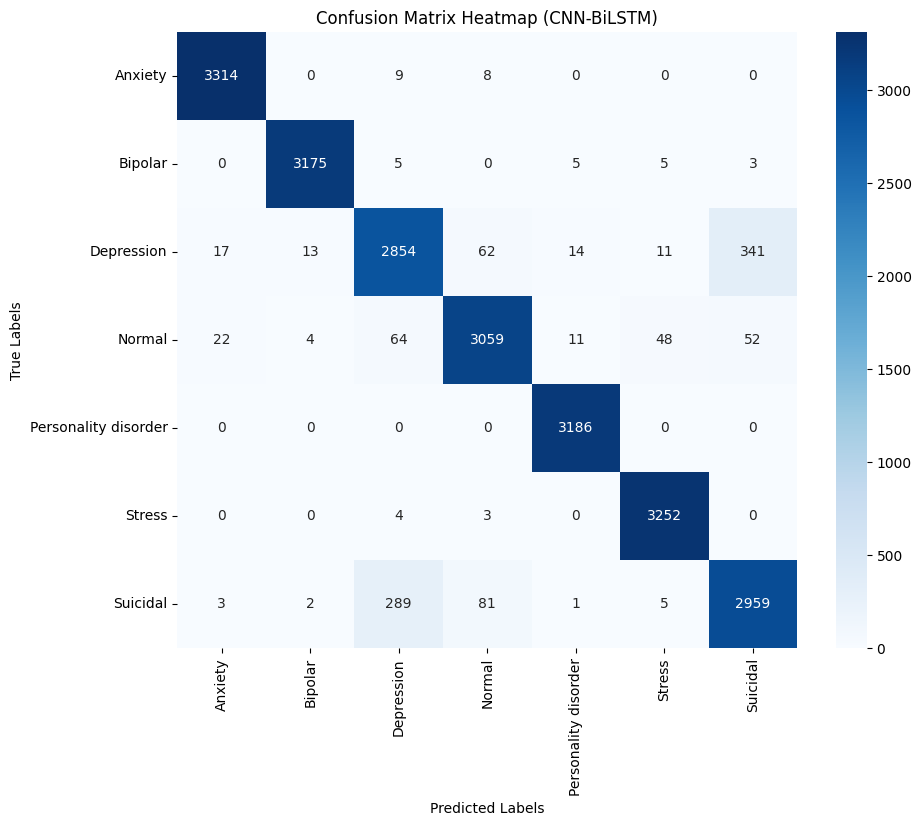

Classification Report:
                      precision    recall  f1-score   support

             Anxiety     0.9875    0.9949    0.9912      3331
             Bipolar     0.9941    0.9944    0.9942      3193
          Depression     0.8850    0.8617    0.8732      3312
              Normal     0.9521    0.9383    0.9452      3260
Personality disorder     0.9904    1.0000    0.9952      3186
              Stress     0.9792    0.9979    0.9884      3259
            Suicidal     0.8820    0.8859    0.8839      3340

            accuracy                         0.9527     22881
           macro avg     0.9529    0.9533    0.9530     22881
        weighted avg     0.9523    0.9527    0.9525     22881



In [14]:
# Generate predictions and compute evaluation metrics
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap (CNN-BiLSTM)')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=4))

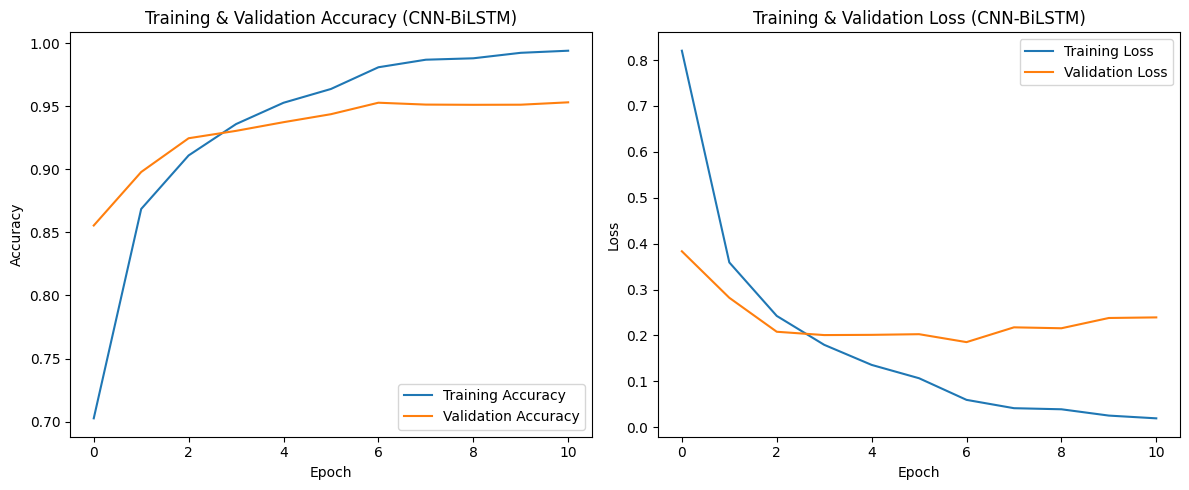

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy (CNN-BiLSTM)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss (CNN-BiLSTM)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


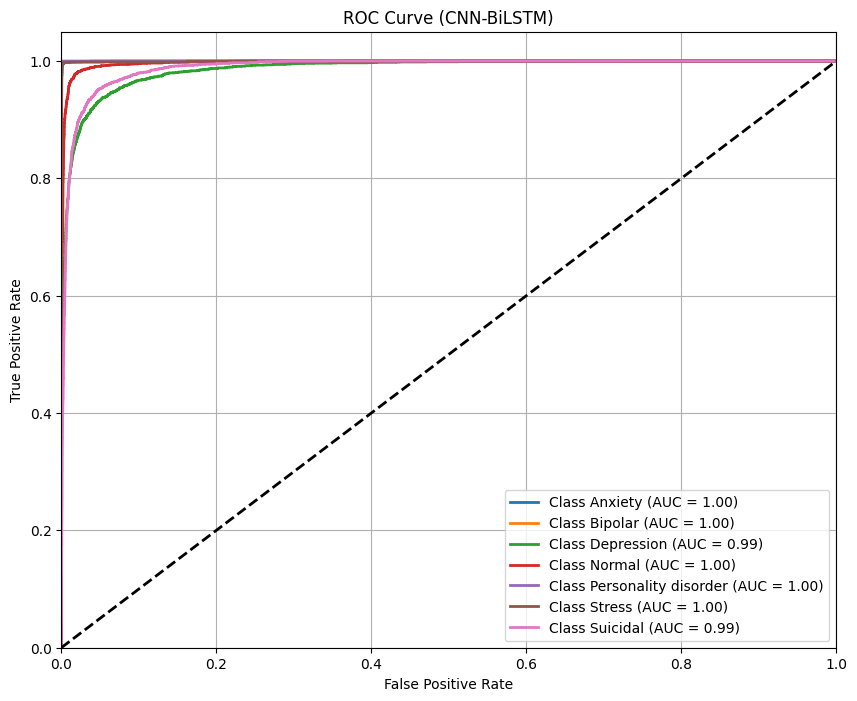

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC curve setup
n_classes = y_categorical.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves using a colormap 
plt.figure(figsize=(10, 8))
colors = plt.cm.tab10.colors  

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
             label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (CNN-BiLSTM)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



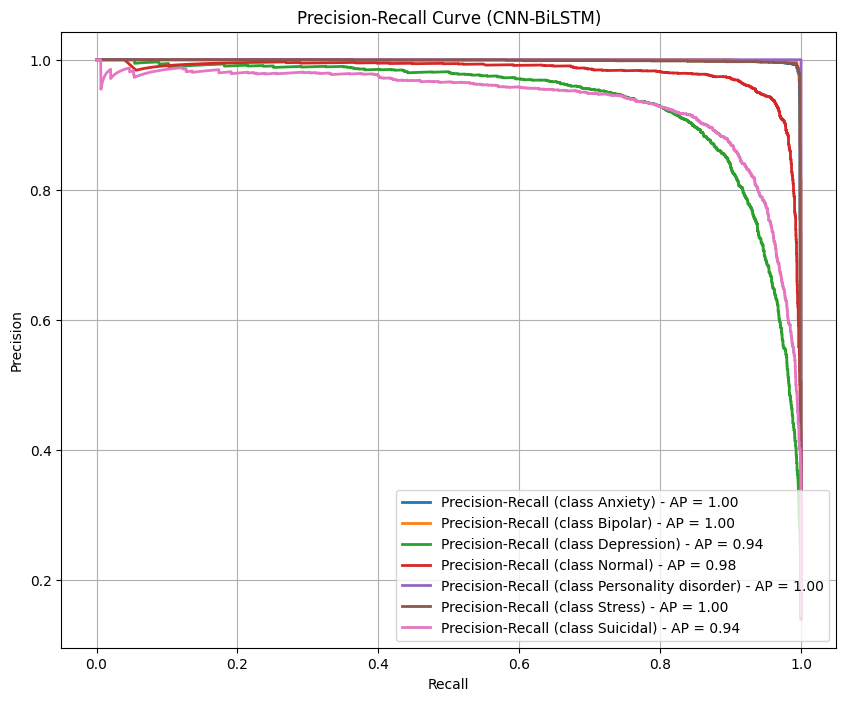

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall curve and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_probs[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred_probs[:, i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Precision-Recall (class {label_encoder.classes_[i]}) - AP = {average_precision[i]:0.2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (CNN-BiLSTM)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

